<a href="https://colab.research.google.com/github/martin23-sg/Calculadora_De_Arboles/blob/main/Calculadora_De_Arboles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto de Productos Financieros Derivados**



## **Calculadora de Árboles Multiplicativos**

**Descripción:** En esta ocasión, se presenta una calculadora de árboles multiplicativos. Dicha calculadora es capaz de generar el árbol de precios del activo subyacente, valuar y generar el árbol de valores para opciones tipo call y put tanto europeas, como americanas y también dígitales; además, dicha valuación y generación del árbol del derivado se realizará bajo dos escenarios: subyacente sin dividendos y con dividendos continuos. Adicionalmente, se calcula en cada nodo del árbol el portafolio de cobertura compuesto por $\alpha$ unidades de activo subyacente y $\beta$ unidades en la cuenta de mercado de dinero.

### **Funciones para la Valuación de los Derivados Considerados (Implementación)**

In [1]:
# Paqueterias a utilizar:
import numpy as np
import math as m

In [2]:
# Funciones de los payoffs:

def payoff_call(S, K):
  '''
  Función que calcula el payoff de una opción de tipo call
  Inputs:
  - S: precio del subyacente
  - K: precio de ejercicio

  Output:
  - Payoff de la opción
  '''
  return max(S - K, 0)


def payoff_put(S, K):
  '''
  Función que calcula el payoff de una opción de tipo put
  Inputs:
  - S: precio del subyacente
  - K: precio de ejercicio

  Output:
  - Payoff de la opción
  '''
  return max(K - S, 0)


def payoff_call_digital(S, K, M):
  '''
  Función que calcula el payoff de una opción de tipo put digital
  Inputs:
  - S: precio del subyacente
  - K: precio de ejercicio
  - M: Pago a la fecha de vencimiento

  Output:
  - Payoff de la opción
  '''
  if S > K:
    return M
  else:
    return 0


def payoff_put_digital(S, K, M):
  '''
  Función que calcula el payoff de una opción de tipo put digital
  Inputs:
  - S: precio del subyacente
  - K: precio de ejercicio
  - M: Pago a la fecha de vencimiento

  Output:
  - Payoff de la opción
  '''
  if S < K:
    return M
  else:
    return 0

In [3]:
def generar_arbol_suby(S1, u, d, N):
  '''
  Función para construir o generar el árbol multiplicativo de precios del subyacente.
  Inputs:
  - S1: Precio inicial del subyacente
  - u: Factor de subida
  - d: Factor de bajada
  - N: Número de periodos

  Outputs:
  - S: Lista con los precios del subyacente (en el orden de los nodos del árbol)
  '''
  S = [float(S1)] # Lista que contendrá los precios del subyacente en el árbol
  for i in range(1,N+1): # Ciclo para el número de periodos
    for j in range(i,-1,-1): # Ciclo para el número de 'bajadas' hasta el i-ésimo periodo
      S.append(S1*d**(j)*u**(i-j))
  return np.array(S)

In [4]:
def valuar_opcion(precios_suby, u, d, N, T, r, K, rd, f, tipo = "europea", M=0):
  '''
  Función para valuar opciones de tipo call y put europeas, call y put americanas y call y put digitales (europeas) en un árbol
  binomial multiplicativo y construir el portafolio de cobertura, todo bajo los escenarios de subyacente sin dividendos y con
  dividendos continuos.
  Inputs:
  - precios_suby: arreglo de precios del subyacente
  - u: Factor de subida
  - d: Factor de bajada
  - N: Número de periodos
  - T: Tiempo al vencimiento (en años)
  - r: Tasa de interés anual de la cuenta de mercado de dinero (expresada en forma decimal, NO porcentaje)
  - K: Precio de ejercicio (strike)
  - rd: Tasa de dividendos continuos (expresada en forma decimal, NO porcentaje)
  - f: Función de payoff de la opción
  - tipo: Tipo de opción -europea o americana- (por default se valúan opciones de tipo europeas)

  Outputs:
  - X_sin_div: Arreglo con los valores del derivado en el caso sin dividendos
  - X_div_cont: Arreglo con los valores del derivado en el caso con dividendos continuos
  - port_cob_sin_div: Arreglo con los componentes del portafolio de cobertura en el caso sin dividendos
  - port_cob_div_cont: Arreglo con los componentes del portafolio de cobertura en el caso con dividendos continuos
  '''
  ## -Inicialización de los objetos a devolver en la función-
  # Para los valores del derivado:
  num_nodos = len(precios_suby) # Número de nodos del árbol del derivado
  X_sin_div = np.zeros(num_nodos) # Arreglo para almacenar los valores del derivado en el caso sin dividendos
  # Para los valores del portafolio de cobertura:
  num_port = num_nodos-(N+1) # Número de nodos con portafolio de cobertura (exceptuando los nodos finales)
  port_cob_sin_div = np.zeros((num_port,2)) # Arreglo para almacenar los valores del portafolio de cobertura en el caso sin dividendos
  port_cob_div_cont = np.zeros((num_port,2))# Arreglo para almacenar los valores del portafolio de cobertura en el caso con dividendos continuos
  #-------------------------------------------------------------------------------------------------------------------------------------------
  delta = T/N # Longitud de cada periodo
  B = m.exp(-r*delta) # Proceso valor de la cuenta de mercado de dinero para traer a Valor Presente
  B_E = m.exp(-rd*delta) # Proceso valor del pago de dividendos continuos (para traer a Valor Presente)
  #------------------------------------------------------------------------------------------------------------------------------------------
  B_inv = 1/B # Proceso valor de la cuenta de mercado de dinero para llevar a Valor Futuro
  B_E_inv = 1/B_E # Proceso valor del pago de dividendos continuos (para llevar a Valor Futuro)
  #------------------------------------------------------------------------------------------------------------------------------------------
  # Dado que el horizonte de 0 a T se divide en N peridos todos de longitud delta y como se trata de un árbol multiplicativo,
  # tendremos una sola q para cada escenario:
  q_sin_div = (B_inv-d)/(u-d) # Probabilidad de riesgo neutral para caso sin dividendos
  q_div_cont = ((B_inv*B_E)-d)/(u-d) # Probabilidad de riesgo neutral para caso con dividendos continuos
  #-------------------------------------------------------------------------------------------------------------------------------------------

  # Valores del Derivado en los nodos finales
  if f==payoff_call_digital or f==payoff_put_digital:
    for i in range(0, N+1): # Recorrido de los N+1 nodos finales
      X_sin_div[-1-i] = f(precios_suby[-1-i],K,M) # Se agrega el valor del payoff en los nodos finales
  else:
    for i in range(0, N+1): # Recorrido de los N+1 nodos finales
      X_sin_div[-1-i] = f(precios_suby[-1-i],K) # Se agrega el valor del payoff en los nodos finales
  X_div_cont = X_sin_div.copy() # Valores del derivado para el caso con dividendos continuos

  # Cálculo de los valores del derivado y de los componentes del portafolio de cobertura para los dos escenarios considerados
  pos = num_port # Posición para iniciar a trabajar backwards
  for k in range(N - 1, -1, -1): # Ciclo para recorrer los periodos de forma backwards (desde el tiempo (N-1)*delta hasta el primer nodo (al tiempo 0*delta))
    pos -= k+1
    for i in range(k+1): # Ciclo para recorrer los (k+1) nodos en el correspondiente tiempo k*delta
      if tipo == "americana":
        valor_ejercicio = f(precios_suby[pos + i], K) # Valor en caso de ejercer la opción en el nodo actual del árbol
        valor_suby_actual = precios_suby[pos + i] # Precio del subyacente en el nodo actual
        valor_suby_abajo = precios_suby[pos + i + k + 1] # Precio del subyacente "abajo" (en caso de bajar a partir del nodo actual)
        # Para caso sin dividendos:
        valor_der_abajo = X_sin_div[pos + i + k + 1] # Valor del derivado "abajo" (en caso de bajar a partir del nodo actual)
        valor_esperado_der = B*(q_sin_div*X_sin_div[pos + i + k + 2] + (1-q_sin_div)*valor_der_abajo) # Valor presente de la esperanza de X bajo Q
        if valor_esperado_der >= valor_ejercicio:
          X_sin_div[pos + i] = valor_esperado_der
        else:
          X_sin_div[pos + i] = valor_ejercicio
        alpha = (valor_der_abajo-B_inv*valor_esperado_der)/(valor_suby_abajo-B_inv*valor_suby_actual)
        port_cob_sin_div[pos + i] = [alpha, valor_esperado_der-alpha*valor_suby_actual]
        # Para caso con dividendos continuos:
        valor_der_abajo = X_div_cont[pos + i + k + 1] # Valor del derivado "abajo" (en caso de bajar a partir del nodo actual)
        valor_esperado_der = B*(q_div_cont*X_div_cont[pos + i + k + 2] + (1-q_div_cont)*valor_der_abajo) # Valor presente de la esperanza de X bajo Q
        if valor_esperado_der >= valor_ejercicio:
          X_div_cont[pos + i] = valor_esperado_der
        else:
          X_div_cont[pos + i] = valor_ejercicio
        alpha = (valor_der_abajo-B_inv*valor_esperado_der)/(B_E_inv*valor_suby_abajo-B_inv*valor_suby_actual)
        port_cob_div_cont[pos + i]= [alpha, valor_esperado_der-alpha*valor_suby_actual]

      else: # En caso de opciones call europea, put europea, call digital o put digital
        delta_S = (precios_suby[pos + i + k + 2]- precios_suby[pos + i + k + 1]) # Diferencia en S (precio del subyacente)
        valor_suby_actual = precios_suby[pos + i] # Precio del subyacente en el nodo actual
        # Para caso sin dividendos
        valor_der_arriba = X_sin_div[pos + i + k + 2] # Valor del derivado en el nodo de "arriba" X_u (en caso de subir a partir del nodo actual)
        valor_der_abajo = X_sin_div[pos + i + k + 1] # Valor del derivado en el nodo de "abajo" X_d (en caso de bajar a partir del nodo actual)
        X_sin_div[pos + i] = B*(q_sin_div*valor_der_arriba + (1-q_sin_div)*valor_der_abajo) # Valor en caso de ejercer la opción en el nodo actual del árbol
        alpha = (valor_der_arriba-valor_der_abajo)/delta_S # Componente alpha del portafolio de cobertura
        port_cob_sin_div[pos + i] = [alpha, X_sin_div[pos + i]-alpha*valor_suby_actual]
        # Para caso con dividendos continuos
        valor_der_arriba = X_div_cont[pos + i + k + 2] # Valor del derivado "arriba" X_u (en caso de subir a partir del nodo actual)
        valor_der_abajo = X_div_cont[pos + i + k + 1] # Valor del derivado "abajo" X_d (en caso de bajar a partir del nodo actual)
        X_div_cont[pos + i] = B*(q_div_cont*valor_der_arriba + (1-q_div_cont)*valor_der_abajo)  # Valor en caso de ejercer la opción en el nodo actual del árbol
        alpha = B_E*(valor_der_arriba-valor_der_abajo)/delta_S # Componente alpha del portafolio de cobertura
        port_cob_div_cont[pos + i] = [alpha, X_div_cont[pos + i]-alpha*valor_suby_actual]

  return X_sin_div, X_div_cont, port_cob_sin_div, port_cob_div_cont

### **Funciones de Interacción y Presentación de Resultados para la Calculadora**

In [7]:
# Para Presentación de Resultados
def convertir_en_dicc(arreglo, cadena ="Nodo "):
  '''
  Función para convertir un arreglo de listas de valores en un diccionario asignando el nodo correspondiente
  Inputs:
  - arreglo: Arreglo numpy de valores numéricos
  - cadena: Objeto de tipo 'string' para identificar cada nodo. Por default se tiene "Nodo ".

  Output:
  - dicc: Arreglo convertido en diccionario, redondeando cada elemento a 4 decimales (para presentación de resultados)
  '''
  dicc = {}
  arreglo = np.round(arreglo, 4)
  for i in range(len(arreglo)):
    dicc[cadena + str(i+1)] = arreglo[i].tolist()
  return dicc

In [8]:
# Para menú y solicitud de valores
def mostrar_menuPrincipal():
  print("\n=== CALCULADORA DE ÁRBOLES MULTIPLICATIVOS ===")
  print("¡Hola!, ¿con cuál tipo de derivado deseas trabajar en esta ocasión?")
  print("1. Opción Call Europea")
  print("2. Opción Put Europea")
  print("3. Opción Call Americana")
  print("4. Opción Put Americana")
  print("5. Opción Call Digital")
  print("6. Opción Put Digital")
  print("7. Salir")

def solicitar_numero_float(mensaje):
    '''
    Función para solicitar a un usuario un número de tipo float hasta ingresar uno válido.
    Input:
    Mensaje: Mensaje que se muestra al usuario (de tipo string)

    Output:
    Número float ingresado correctamente
    '''
    while True:
        try:
            return float(input(mensaje))
        except ValueError:
            print("Error: Debes ingresar números válidos. Intenta nuevamente.")

def solicitar_numero_int(mensaje):
    '''
    Función para solicitar a un usuario un número de tipo int hasta ingresar uno válido.
    Input:
    Mensaje: Mensaje que se muestra al usuario (de tipo string)

    Output:
    Número int ingresado correctamente
    '''
    while True:
        try:
            return int(input(mensaje))
        except ValueError:
            print("Error: Debes ingresar un número entero (sin decimales). Intenta nuevamente.")

### **Calculadora de Árboles**

In [9]:
def calculadora_arboles():
  while True:
    mostrar_menuPrincipal()
    # Solicitud de una opción del menú
    while True:
      opcion = solicitar_numero_int("Elige una opción (1-7): ")
      if 1 <= opcion <= 7:
        break
      else:
        print("Opción no válida. Intenta nuevamente.")

    if opcion == 7:
      print("Saliendo de la Calculadora...")
      break
    # ---------------------------------------------Solicitud de valores--------------------------------------------
    S1 = solicitar_numero_float("Ingresa el precio inicial del subyacente: ")

    while True:
      u = solicitar_numero_float("Ingresa el factor 'u' de subida (mayor que 1): ")
      if u > 1:
        break
      else:
        print("El factor 'u' debe ser mayor a 1. Intenta nuevamente.")

    while True:
      d = solicitar_numero_float("Ingresa el factor 'd' de bajada (menor que 1): ")
      if d < 1:
        break
      else:
        print("El factor 'd' debe ser menor a 1. Intenta nuevamente.")

    T = solicitar_numero_float("Ingresa el tiempo de vencimiento de la opción (en años): ")

    N = solicitar_numero_int("Ingresa el número de periodos del árbol: ")

    K = solicitar_numero_float("Ingresa el precio de ejercicio (strike): ")

    r = solicitar_numero_float("Ingresa la tasa de interés anual (en decimal) de la cuenta de mercado de dinero: ")

    r_d = solicitar_numero_float("Ingresa la tasa continua anual (en decimal) del pago de dividendos: ")
    # -------------------------------------------------------------------------------------------------------------
    arbol_suby = generar_arbol_suby(S1, u, d, N) # Construcción del árbol de precios del subyacente
    # -------------------------------------------------------------------------------------------------------------
    if opcion == 1:
      print("\n-Derivado: Call Europea-")
      V_sin_div, V_div_cont, port_cob_sin_div, port_cob_div_cont = \
      valuar_opcion(arbol_suby, u, d, N, T, r, K, r_d, payoff_call)

    elif opcion == 2:
      print("\n-Derivado: Put Europea-")
      V_sin_div, V_div_cont, port_cob_sin_div, port_cob_div_cont = \
      valuar_opcion(arbol_suby, u, d, N, T, r, K, r_d, payoff_put)

    elif opcion == 3:
      print("\n-Derivado: Call Americana-")
      V_sin_div, V_div_cont, port_cob_sin_div, port_cob_div_cont= \
      valuar_opcion(arbol_suby, u, d, N, T, r, K, r_d, payoff_call, tipo = "americana")

    elif opcion == 4:
      print("\n-Derivado: Put Americana-")
      V_sin_div, V_div_cont, port_cob_sin_div, port_cob_div_cont = \
      valuar_opcion(arbol_suby, u, d, N, T, r, K, r_d, payoff_put, tipo = "americana")

    elif opcion == 5:
      M = solicitar_numero_float("Ingresa el pago (M) a la fecha de vencimiento: ")
      print("\n-Derivado: Call Digital-")
      V_sin_div, V_div_cont, port_cob_sin_div, port_cob_div_cont = \
      valuar_opcion(arbol_suby, u, d, N, T, r, K, r_d, payoff_call_digital, M = M)

    elif opcion == 6:
      M = solicitar_numero_float("Ingresa el pago (M) a la fecha de vencimiento: ")
      print("\n-Derivado: Put Digital-")
      V_sin_div, V_div_cont, port_cob_sin_div, port_cob_div_cont = \
      valuar_opcion(arbol_suby, u, d, N, T, r, K, r_d, payoff_put_digital, M = M)

    arbol_suby =[round(x, 4) for x in arbol_suby] # Redondeo de los precios del subyacente (para presentación de resultados)
    print("==============================================================================================================")
    print(f'El árbol del activo subyacente es: {convertir_en_dicc(arbol_suby)}')
    print("==============================================================================================================")
    print('Caso de Subyacente Sin Dividendos.')
    print(f'El árbol del derivado en el caso sin dividendos es: {convertir_en_dicc(V_sin_div)}')
    print(f'EL portafoloio de cobertura (alpha, beta) es: {convertir_en_dicc(port_cob_sin_div)}')
    print(f'El precio de este derivado en t=0 es: {round(V_sin_div[0], 2)} unidades monetarias')
    print("===============================================================================================================")
    print('Caso de Subyacente Con Dividendos Continuos.')
    print(f'El árbol del derivado en el caso con dividendos continuos es: {convertir_en_dicc(V_div_cont)}')
    print(f'El portafoloio de cobertura (alpha, beta) es: {convertir_en_dicc(port_cob_div_cont)}')
    print(f'El precio de este derivado en t=0 es: {round(V_div_cont[0], 2)} unidades monetarias')
    print("==============================================================================================================")

### Pruebas

#### **Ejemplos ilustrativos del funcionamiento de la calculadora en todos los casos**

In [17]:
# Ejemplo ilustrativo con cada tipo de opción considerada.
if __name__ == '__main__':
    calculadora_arboles()


=== CALCULADORA DE ÁRBOLES MULTIPLICATIVOS ===
¡Hola!, ¿con cuál tipo de derivado deseas trabajar en esta ocasión?
1. Opción Call Europea
2. Opción Put Europea
3. Opción Call Americana
4. Opción Put Americana
5. Opción Call Digital
6. Opción Put Digital
7. Salir
Elige una opción (1-7): 1
Ingresa el precio inicial del subyacente: 50
Ingresa el factor 'u' de subida (mayor que 1): 1.1
Ingresa el factor 'd' de bajada (menor que 1): 0.95
Ingresa el tiempo de vencimiento de la opción (en años): 0.5
Ingresa el número de periodos del árbol: 6
Ingresa el precio de ejercicio (strike): 50
Ingresa la tasa de interés anual (en decimal) de la cuenta de mercado de dinero: 0.05
Ingresa la tasa continua anual (en decimal) del pago de dividendos: 0.03

-Derivado: Call Europea-
El árbol del activo subyacente es: {'Nodo 1': 50.0, 'Nodo 2': 47.5, 'Nodo 3': 55.0, 'Nodo 4': 45.125, 'Nodo 5': 52.25, 'Nodo 6': 60.5, 'Nodo 7': 42.8687, 'Nodo 8': 49.6375, 'Nodo 9': 57.475, 'Nodo 10': 66.55, 'Nodo 11': 40.7253, 

#### **Ejemplos del funcionamiento de la calculadora ante ingreso de valores no válidos**

In [11]:
# Ingreso de valores no válidos
if __name__ == '__main__':
    calculadora_arboles()


=== CALCULADORA DE ÁRBOLES MULTIPLICATIVOS ===
¡Hola!, ¿con cuál tipo de derivado deseas trabajar en esta ocasión?
1. Opción Call Europea
2. Opción Put Europea
3. Opción Call Americana
4. Opción Put Americana
5. Opción Call Digital
6. Opción Put Digital
7. Salir
Elige una opción (1-7): uno
Error: Debes ingresar un número entero (sin decimales). Intenta nuevamente.
Elige una opción (1-7): 8.9
Error: Debes ingresar un número entero (sin decimales). Intenta nuevamente.
Elige una opción (1-7): 9
Opción no válida. Intenta nuevamente.
Elige una opción (1-7): 1
Ingresa el precio inicial del subyacente: cien
Error: Debes ingresar números válidos. Intenta nuevamente.
Ingresa el precio inicial del subyacente: 100
Ingresa el factor 'u' de subida (mayor que 1): uno punto cero cinco
Error: Debes ingresar números válidos. Intenta nuevamente.
Ingresa el factor 'u' de subida (mayor que 1): 1.05
Ingresa el factor 'd' de bajada (menor que 1): cero.97
Error: Debes ingresar números válidos. Intenta nueva

### **Fórmulas de Valuación para los Derivados Considerados (Expresiones Matemáticas)**

El objetivo de esta sección es  mostrar las fórmulas matemáticas que se utilizaron en la implementación de la calculadora de árboles. De este modo, vamos a comenzar recordando que la valuación de instrumentos derivados sobre árboles binomiales **miltiperiodo** consiste en que, partiendo de los nodos finales del árbol del derivado, cuyo valor -*payoff*- se conoce a priori, se trabaja entonces de forma *"backwards"* (de los nodos finales hacía el nodo inicial) replicando la metodología del modelo binomial de **un sólo periodo**. Es así que, resulta conveniente recordar brevemente las fórmulas para el caso de un sólo periodo y que aplican a cada subárbol en árboles multiperiodo. A continuación se presentan gráficamente los árboles de un sólo periodo de los valores del derivados $\{X\}$ y del precio del subyacente $\{S\}$:

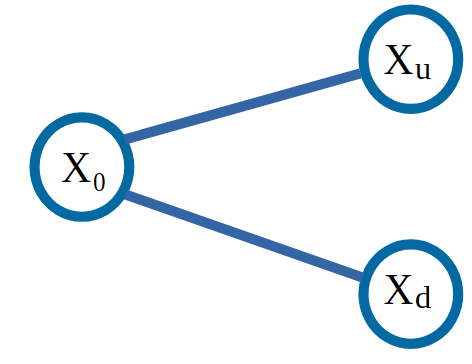  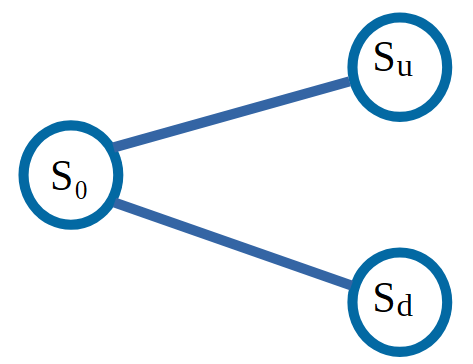

Ahora, vamos a considerar en primer lugar a $B(t,T)$ y $B_E(t,T)$ los procesos de valor en el tiempo de la cuenta de mercado de dinero y del pago de dividendos en el horizonte temporal de $t$ a $T$, respectivamente. Para el caso del proceso $B_E(t, T)$, sí al tiempo $t$ se tienen $A$ unidades del subyacente, entonces al tiempo $T$ se tendrán $B^{-1}_E(t,T)A$ unidades de subyacente; mientras que, el proceso $B(t,T)$ nos dice el valor que tiene en $t$ una unidad monetaria que se tendrá en $T$ (es decir, se trata de un proceso de valor presente). Para el caso de árboles de un sólo periodo tomamos $t=0$, de modo que tendremos lo siguiente:

*   **Para Derivados Europeos**.

    Por un lado, cuando el subyacente **no paga dividendos**, tenemos que el valor del derivado en el nodo inicial es $X_0 = B(0,T)\left[qX_u+(1-q)X_d\right]$, donde $q$ es la probabilidad de riesgo neutral y está dada por $q=\frac{B^{-1}(0, T) - d}{u-d}$. Además, la composición del portafolio de cobertura en el nodo inicial (nodo $0$) está dado por:
    
    $\alpha = \frac{X_u-X_d}{S_u-S_d} = \frac{X_u-B^{-1}(0, T)X_0}{S_u-B^{-1}(0, T)S_0} = \frac{X_d-B^{-1}(0, T)X_0}{S_d-B^{-1}(0, T)S_0}$, y
    
    $\beta=B(0,T)\left[X_u - \frac{X_u-X_d}{S_u-S_d}S_u\right] = B(0,T)\left[X_d-\frac{X_u-X_d}{S_u-S_d}S_d\right] = X_0 - \alpha S_0$
    
    Por otro lado, cuando el subyacente paga dividendos, tenemos que el valor del derivado en el nodo inicial está dado por $X_0=B(0,T)\left[qX_u+(1-q)X_d\right]$, donde $q$ es la medida de riesgo neutral, pero ahora está dada por $q=\frac{B^{-1}(0, T)B_E(0,T)-d}{u-d}$. Además, la composición del portafolio de cobertura en el nodo inicial está dado por:
    
    $\alpha = B_E(0,T)\frac{X_u-X_d}{S_u-S_d} =\frac{X_u-B^{-1}(0, T)X_0}{B_E^{-1}(0,T)S_u-B^{-1}(0, T)S_0} = \frac{X_d-B^{-1}(0, T)X_0}{B_E^{-1}(0,T)S_d-B^{-1}(0, T)S_0}$, y
    
    $\beta=B(0,T)\left[X_u - \frac{X_u-X_d}{S_u-S_d}S_u\right] = B(0,T)\left[X_d-\frac{X_u-X_d}{S_u-S_d}S_d\right] = X_0 - \alpha S_0$

*   **Para Derivados Americanos**

    En este caso, nos apoyamos en las fórmulas anteriores para derivados europeos. Por un lado, el valor del derivado en el nodo inicial es $X_0 = máx\left[B(0,T)\left[qX_u+(1-q)X_d\right], X(S_0)\right]$, donde $X(S_0)$ es el *payoff* del derivado aplicado al precio $S_0$ (se trata del valor en caso de ejercer la opción en el nodo $0$) y $q$ es la correspondiente probabilidad de riesgo neutral vista anteriormente tanto para el caso con dividendos como para cuando no hay pago de dividendos. Por otro lado, para el portafolio de cobertura, sí resulta que $X(S_0) \leq B(0,T)\left[qX_u+(1-q)X_d\right]$, los componentes del portafolio de cobertura tienen la misma expresión matemática que para derivados europeos en ambos escenarios: con y sin dividendos; sí por el contrario $B(0,T)\left[qX_u+(1-q)X_d\right]<X(S_0)$ (es decir, $X_0 = X(S_0)$), entonces se tiene un **nodo de ejercicio** donde es óptimo para la parte larga ejercer el derivado y terminar con él, más sí no se ejerce y aún no es la fecha de vencimiento estipulada, entonces los componentes del portafolio en dicho nodo se pueden calcular de la siguiente manera con la correspondiente probabilidad $q$:
    
    $\beta = X_0 - \alpha S_0$, y

    $\alpha = \frac{X_u-B^{-1}(0, T) * \left(B(0,T)\left[qX_u+(1-q)X_d\right]\right)}{S_u-B^{-1}(0, T)S_0} = \frac{X_d-B^{-1}(0,T) * \left(B(0,T)\left[qX_u+(1-q)X_d\right]\right)}{S_d-B^{-1}(0, T)S_0}$ para el caso **sin dividendos**, o bien,

    $\alpha = \frac{X_u-B^{-1}(0, T) * \left(B(0,T)\left[qX_u+(1-q)X_d\right]\right)}{B_E^{-1}(0,T)S_u-B^{-1}(0, T)S_0} = \frac{X_d-B^{-1}(0, T) * \left(B(0,T)\left[qX_u+(1-q)X_d\right]\right)}{B_E^{-1}(0,T)S_d-B^{-1}(0, T)S_0}$ para el caso **con dividendos**.
    

En esta calculadora, para los **valores del derivado** se utilizaron las fórmulas revisadas anteriormente; mientras que para el cálculo de los componenetes del **portafolio de cobertura**, vamos a utilzar $\beta = X_0 - \alpha S_0$ una vez calculado el componente $\alpha$ de la siguiente manera:
*   Para Derivados Europeos

    $\alpha = \frac{X_u-X_d}{S_u-S_d}$ para el caso **sin dividendos**, y
    
    $\alpha = B_E(0,T)\frac{X_u-X_d}{S_u-S_d}$ para el caso **con dividendos**.

*   Para Derivados Americanos
    *   Sí  $B(0,T)\left[qX_u+(1-q)X_d\right]<X(S_0)$:

        $\alpha = \frac{X_d-B^{-1}(0,T) * \left(B(0,T)\left[qX_u+(1-q)X_d\right]\right)}{S_d-B^{-1}(0, T)S_0}$ para el caso **sin dividendos**, y
        
        $\alpha = \frac{X_d-B^{-1}(0, T) * \left(B(0,T)\left[qX_u+(1-q)X_d\right]\right)}{B_E^{-1}(0,T)S_d-B^{-1}(0, T)S_0}$ para el caso **con dividendos**.
      
    *   Sí $X(S_0) \leq B(0,T)\left[qX_u+(1-q)X_d\right]$:

        $\alpha = \frac{X_d-B^{-1}(0, T)X_0}{S_d-B^{-1}(0, T)S_0}$ para el caso **sin dividendos**, y
        
        $\alpha = \frac{X_d-B^{-1}(0, T)X_0}{B_E^{-1}(0,T)S_d-B^{-1}(0, T)S_0}$ para el caso **con dividendos**.